<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/soft_sensor_deveopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft sensor development

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Step 1. Initialization and data onboarding

Initialize libraries, set random number state for reproducibility, and the directory where the figures should be saved to.

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set random state
np.random.seed(42)

# Set directory for figures
figs_dir = "figures" if os.path.isdir("figures") else ""

Fetch data from kaggle:

In [385]:
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

Using Colab cache for faster access to the 'quality-prediction-in-a-mining-process' dataset.


Load data to memory

In [386]:
data = pd.read_csv(data_path)
print(data.shape)

(737453, 24)


Format the data; date column as datetime objects, other columns as decimal numbers.

In [387]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

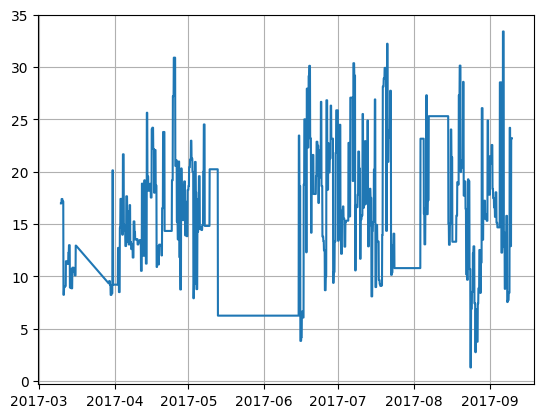

In [388]:
plt.plot(data['date'], data['% Silica Feed'])
plt.grid(which='both')

In [389]:
print(data.head(5))
hourly_sampled = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate', '% Silica Concentrate']

                 date  % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
0 2017-03-10 01:00:00         55.2          16.98      3019.53     557.434   
1 2017-03-10 01:00:00         55.2          16.98      3024.41     563.965   
2 2017-03-10 01:00:00         55.2          16.98      3043.46     568.054   
3 2017-03-10 01:00:00         55.2          16.98      3047.36     568.665   
4 2017-03-10 01:00:00         55.2          16.98      3033.69     558.167   

   Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
0        395.713      10.0664              1.74                       249.214   
1        397.383      10.0672              1.74                       249.719   
2        399.668      10.0680              1.74                       249.741   
3        397.939      10.0689              1.74                       249.917   
4        400.254      10.0697              1.74                       250.203   

   Flotation Column 02 Air Flow  ...  Flotat

---

## Step 2. Data pretreatment

We start by dropping bad time windows from the data

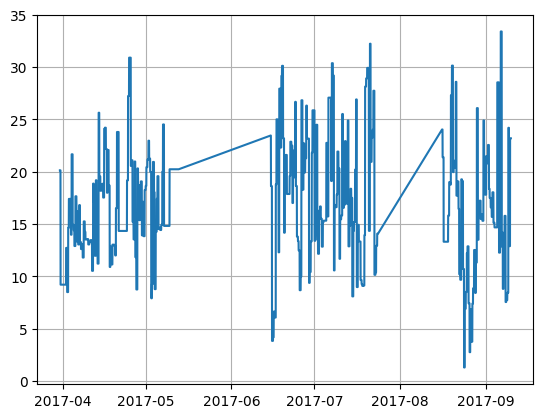

In [390]:
# Usable time windows in the data
start_dates = ["2017-03-31", "2017-06-15", "2017-08-16"]
end_dates = ["2017-05-13", "2017-07-24", data['date'].iloc[-1]]

# Reconstruct the dataset from the usable sets
usable_sets = [data.loc[(data['date']>start_date) & (data['date'] < end_date)] for start_date, end_date in zip(start_dates, end_dates)]
data = pd.concat(usable_sets, ignore_index=True)

# Plot % Silica Feed
plt.plot(data['date'], data['% Silica Feed'])
plt.grid(which='both')

Normalizing the data to $z = \frac{x - \mu}{\sigma}$

In [391]:
# Normalize all columns except the date column
# numerical_cols = data[data.columns[1:]]

# # Calculate means and standard deviations and store them for later use
# train_set = data
# means = train_set[data.columns[1:]].mean()
# stdevs = train_set[data.columns[1:]].std()

# Normalize the data (zero mean, unit variance)
#data[data.columns[1:]] = (numerical_cols - means) / stdevs

Synchronizing the data / resampling the data to a frequency of 1 hour

In [392]:
# Store unsynchronized, original data for later use
#unsynchronized_data = data.copy()

#data = data.groupby("date").mean(numeric_only=True).reset_index()

# Resample the data to 1 hour frequency
print(data.shape)

(461519, 24)


---

## Step 3. Data visualization and PCA


### Fitting the model

Fitting the PCA model

In [393]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize the data for PCA
scaler = StandardScaler()
PCA_data = pd.DataFrame(scaler.fit_transform(data[data.columns[1:]]), columns=data.columns[1:])

# Fit the PCA model
pca = PCA().fit(PCA_data)

### Explained variance

Visualizing the the principal components values and cumulative explained

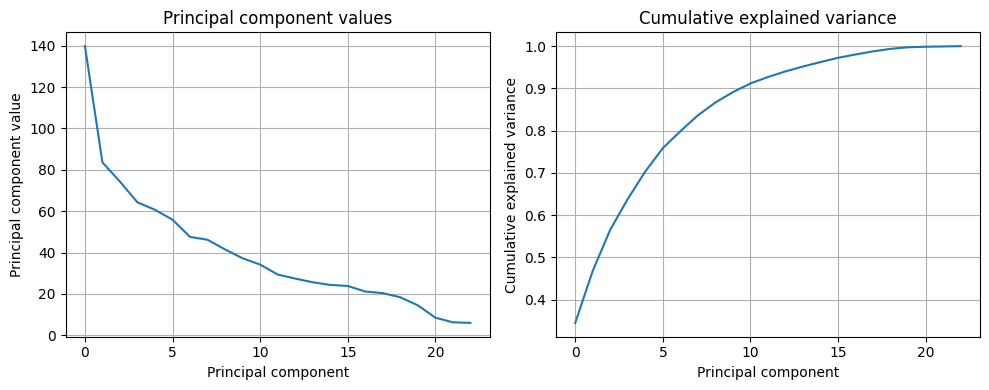

In [394]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots


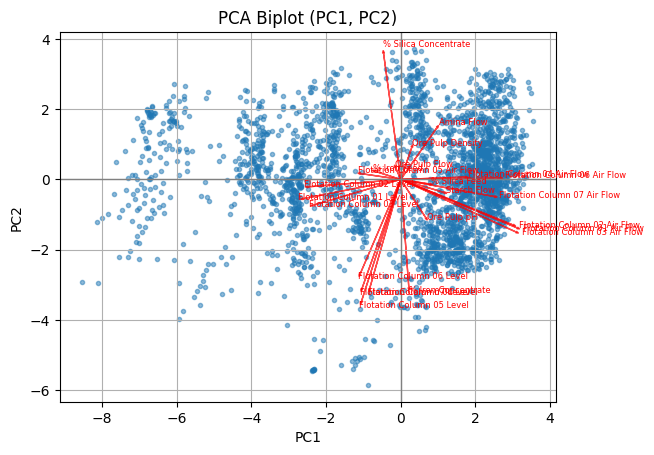

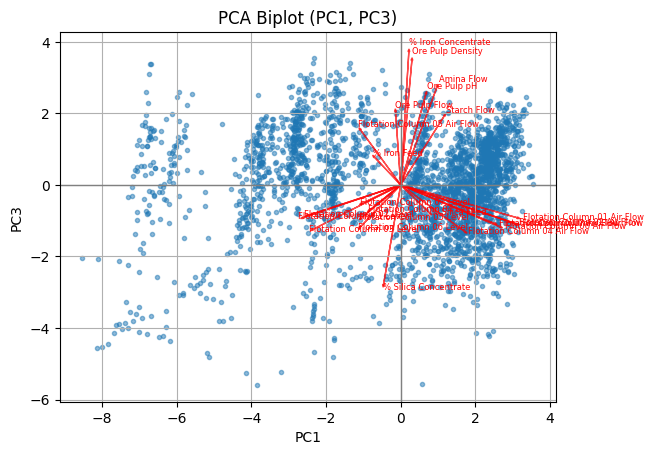

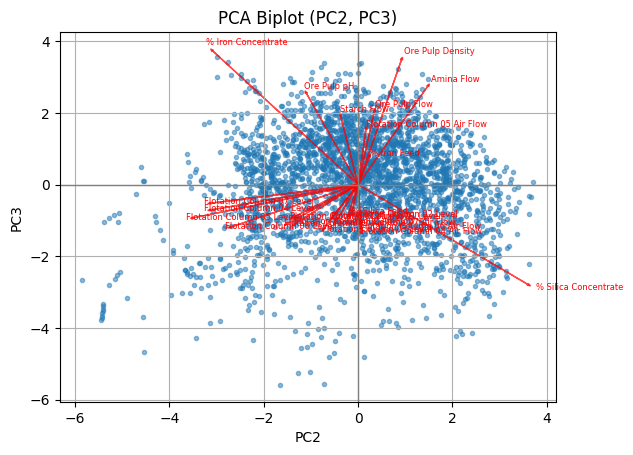

In [395]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    if figs_dir: plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

### Data correlations and distributions

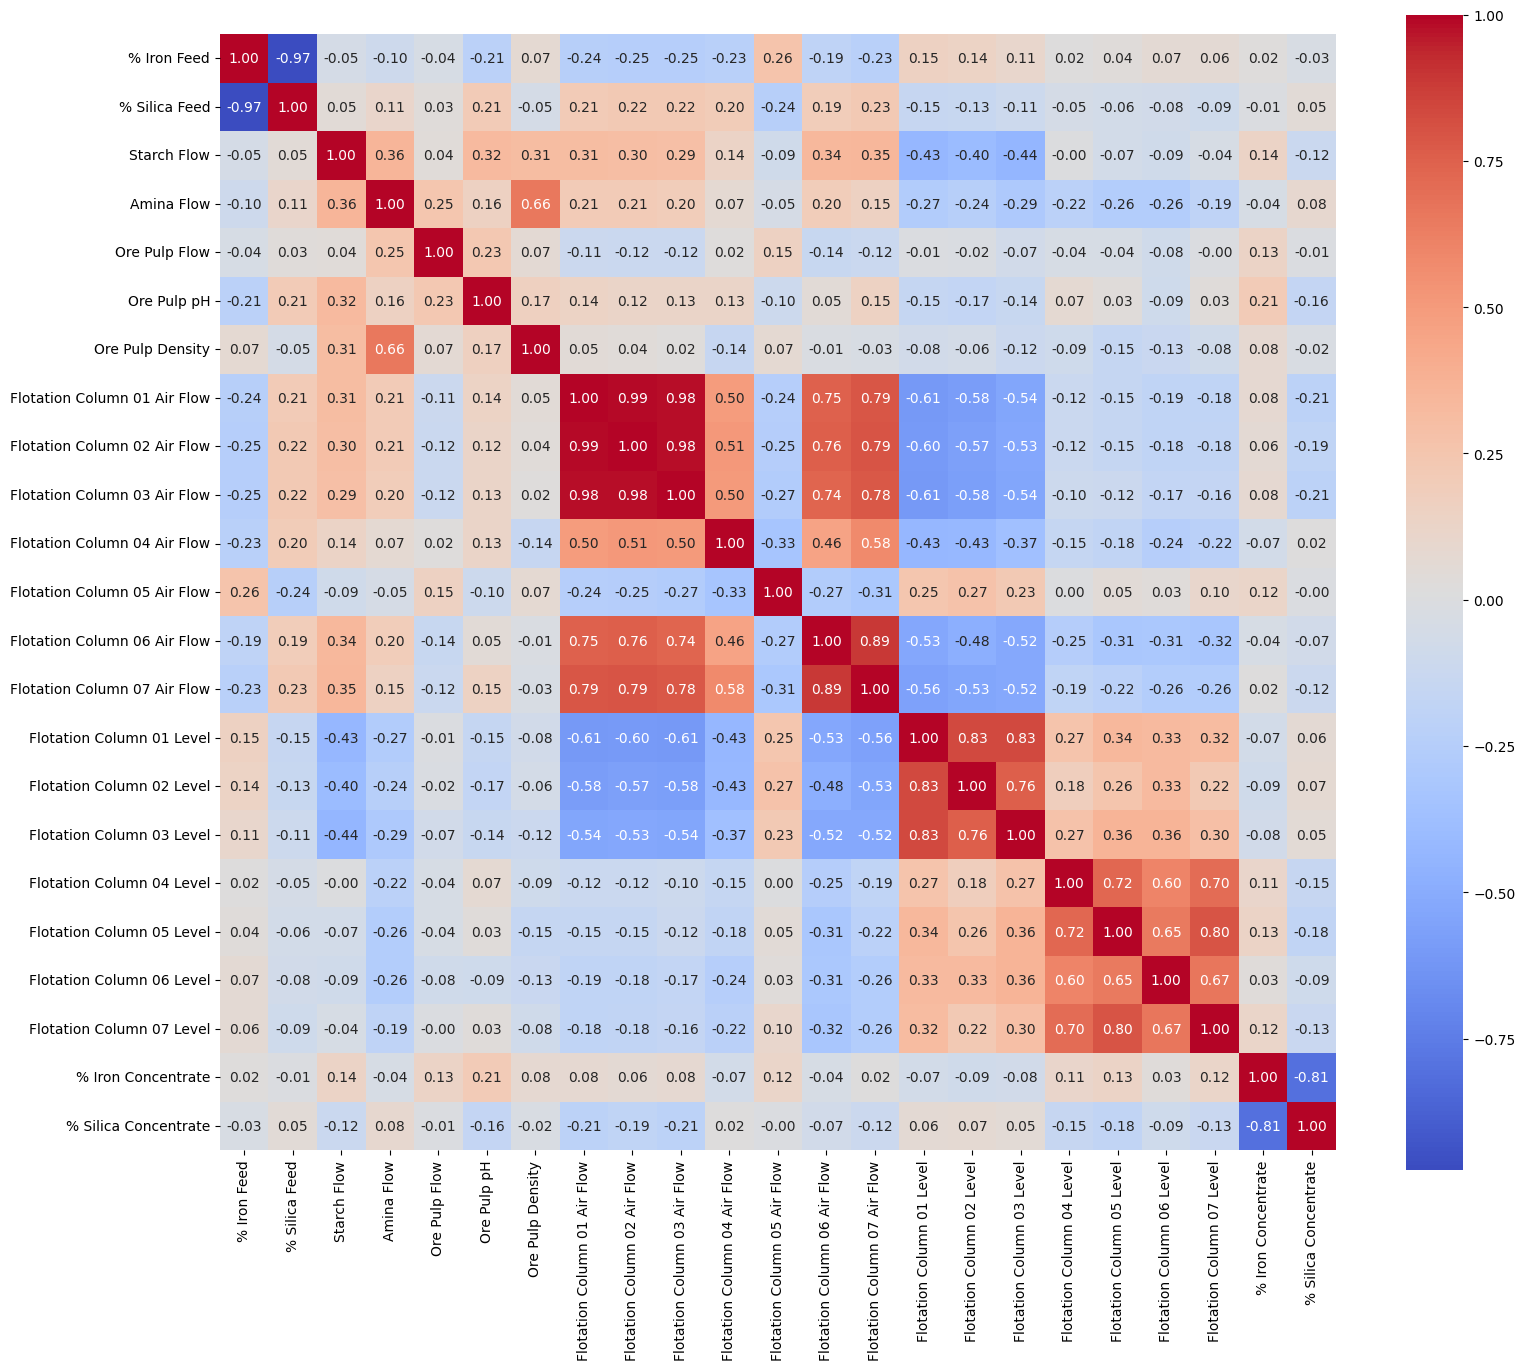

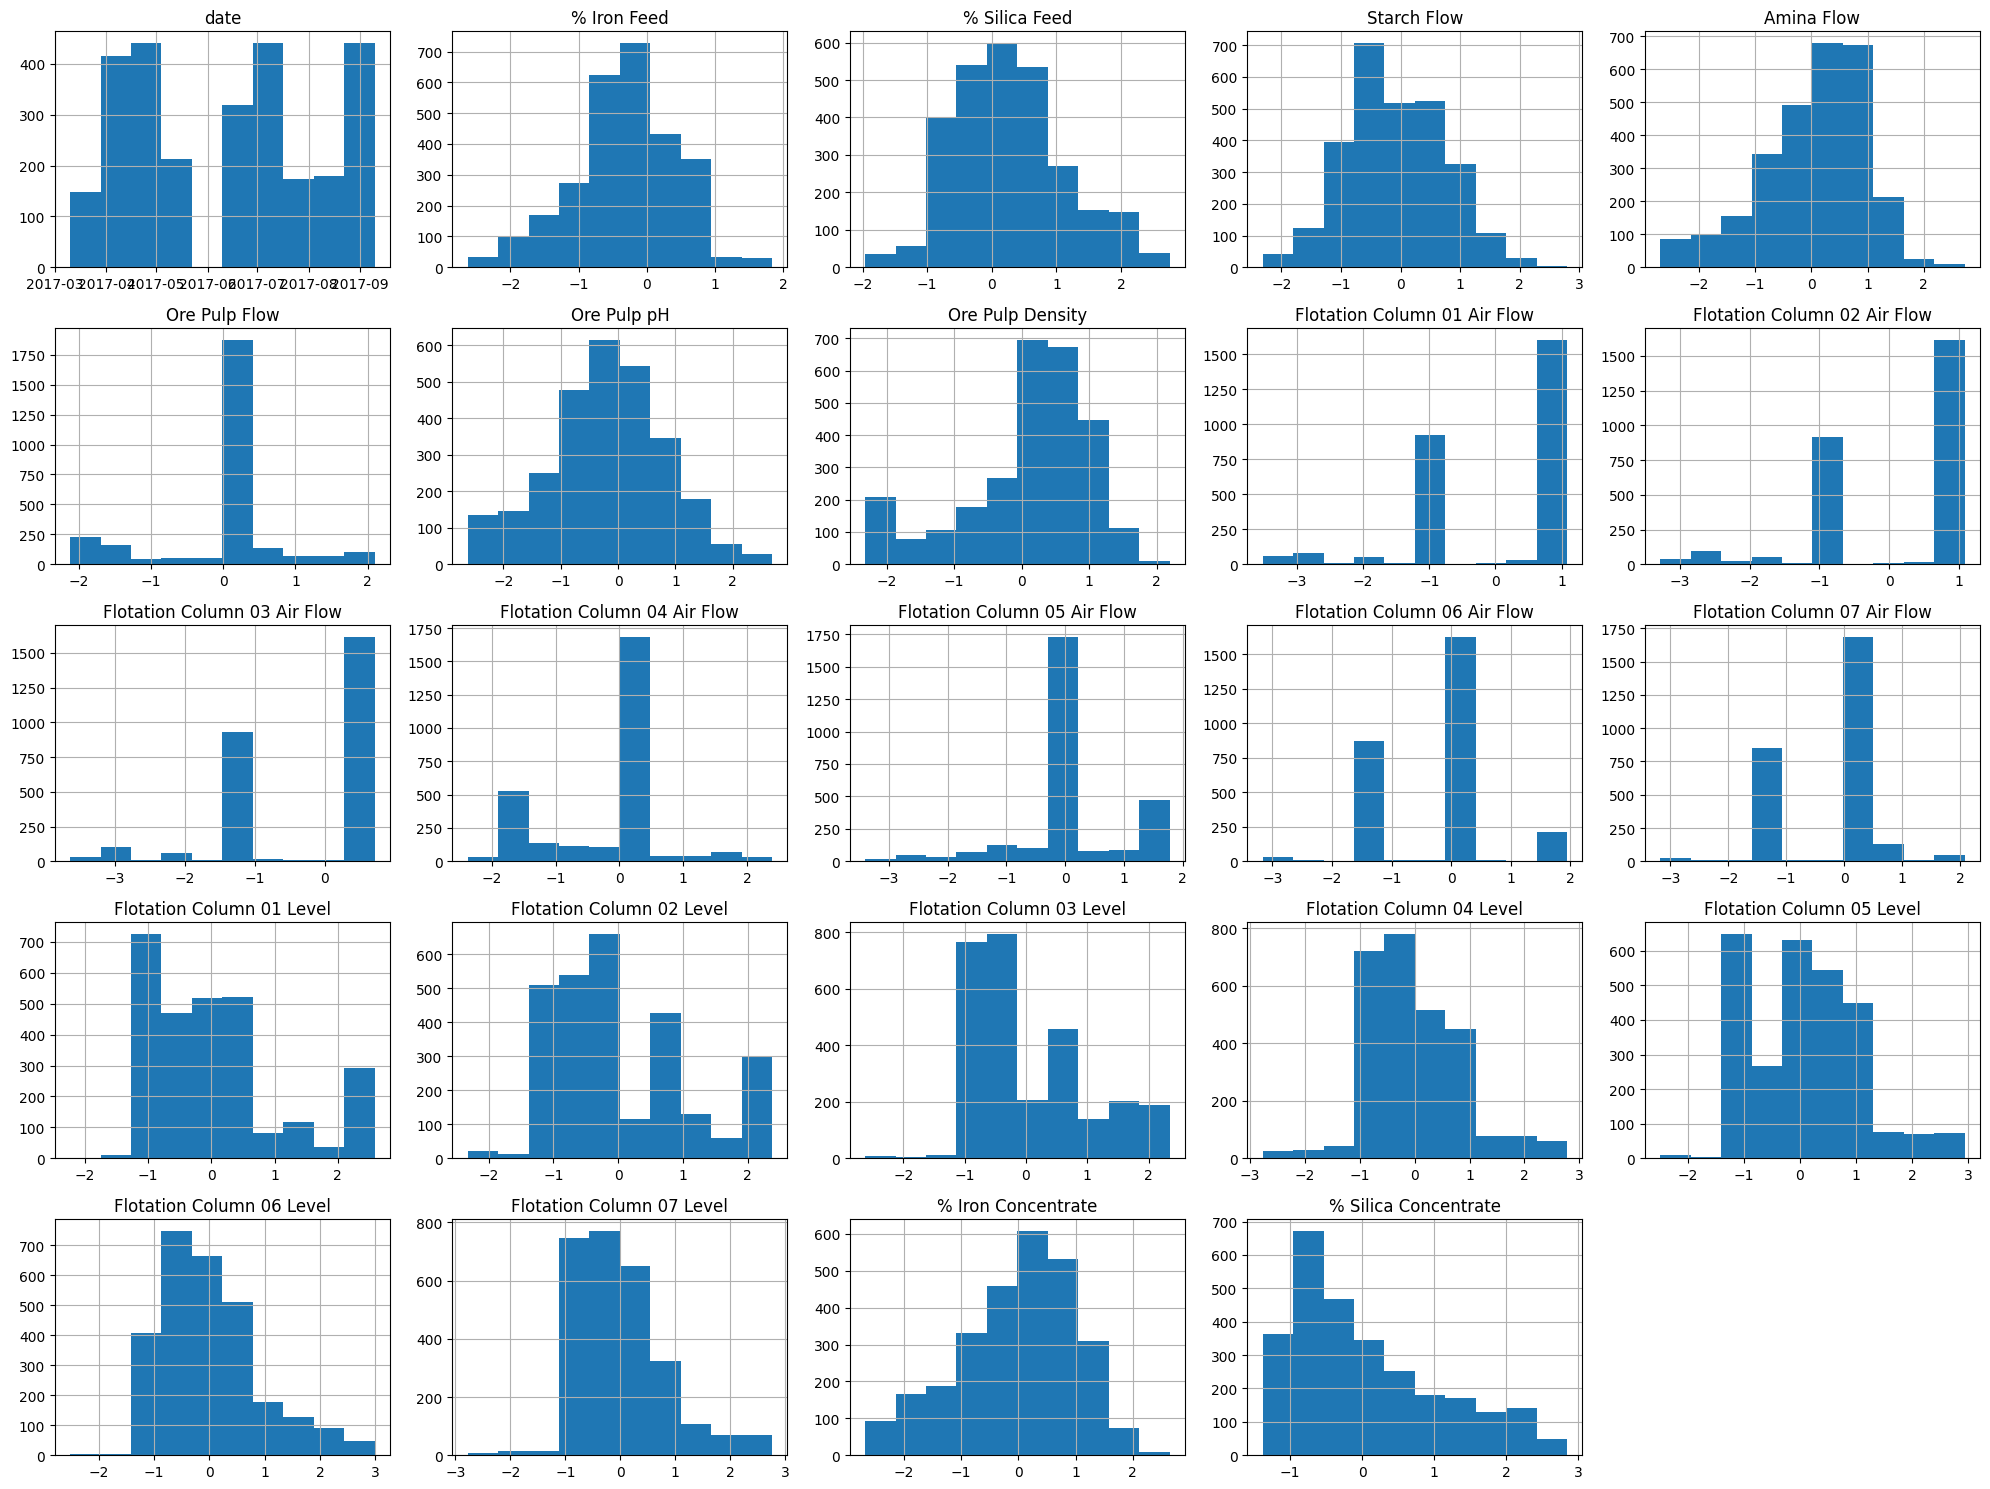

In [396]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
if figs_dir: plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

---

## Model training

### Preparations

Our data modeling process begins from splitting the data to training, validation and test sets. Then we train the dynamic model on


We start by defining the predicted variable and the predictor variables:

**NOTE!** '% Iron Concentrate' is dropped as it can't be used (A-level task).

In [397]:
TARGET_COLUMN = '% Silica Concentrate'
DROP_COLUMNS = ['date', '% Iron Concentrate']

#most_corr = data_corr[TARGET_COLUMN][data_corr[TARGET_COLUMN].abs() > 0.15]
#feature_columns = [c for c in most_corr.index if c not in ['date', '% Iron Concentrate', TARGET_COLUMN]]

feature_columns = [c for c in data.columns if c not in [*DROP_COLUMNS, TARGET_COLUMN]]
print(feature_columns)

['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow', 'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level']


We split the data to training set, validation set and test set. The time series data is divided into 3 distinct windows (we dropped the unusable windows in Data Pretreatment), which gives us a natural way to split the data to the 3 sets. The start and end dates of these time windows are stored in the `start_dates` and `end_dates` arrays, which we can use to split the dataset. 

In [398]:
from math import floor

# Extract usable time windows from the data
usable_sets = [data.loc[(data['date']>start_date) & (data['date'] < end_date)] for start_date, end_date in zip(start_dates, end_dates)]
data_train, data_val, data_test = usable_sets

# train_size, val_size, test_size = 0.7, 0.15, 0.15
# train_end = floor(train_size * len(data))
# val_end = train_end + floor(val_size * len(data))

# # Split the data to training, validation and test sets
# data_train, data_val, data_test = data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]
# print(data_train.shape, data_val.shape, data_test.shape)

We split the data to sets of $X$ and $y$ and scale the data. 

In [399]:
from sklearn.preprocessing import StandardScaler

# Split the training, validation and test sets to sets X and y
X_train, y_train = data_train[feature_columns], data_train[TARGET_COLUMN]
X_val, y_val = data_val[feature_columns], data_val[TARGET_COLUMN]
X_test, y_test = data_test[feature_columns], data_test[TARGET_COLUMN]

# Normalize X_train 
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val, X_test = scaler_X.transform(X_val), scaler_X.transform(X_test)
#y_train = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
#y_val, y_test = scaler_y.transform(y_val.to_numpy().reshape(-1, 1)), scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# Convert arrays back to DataFrames
X_train, X_val, X_test = [pd.DataFrame(X, columns=feature_columns) for X in [X_train, X_val, X_test]]
#y_train, y_val, y_test = [pd.DataFrame(y, columns=[TARGET_COLUMN]) for y in [y_train, y_val, y_test]]

#### Adding lagged variables

We implement a function `make_lagged` for adding lagged variables as new columns to dataset `X`. If both `X` and `y` are passed, `y` the top rows are cut so that `X` and `y` are the same length. The added lags can be changed by passing the array `lags` and the columns which lagged variables are added for can be changed by passing `columns`. 

In [400]:
def make_lagged(X: np.ndarray, y: np.ndarray|None=None, lags: np.ndarray=None, columns: list|None=None) -> np.ndarray|tuple[np.ndarray, np.ndarray]:
    
    # By default return unlagged features and features with lag 1
    if lags is None: lags = np.array([0, 1])
    
    # By default add lagged variables for all columns
    if columns is None: columns = X.columns 

    # Create lagged variables and add them to X
    lagged_vars = [X[columns].shift(lag).add_suffix(f"_lag{lag}" if lag > 0 else "") for lag in lags]
    X_lagged = pd.concat(lagged_vars, axis=1).dropna(axis=0)

    # Return X, or if y was passed, X and y cut to the same length as X (from the top)
    if y is None: return X_lagged
    return X_lagged, y[max(lags):]

#### Implement a function to train a dynamic model

We implement a function which takes training data and labels `X_train` and `y_train`, a number of lags `num_lags` and number of latent variables `num_comps` packed in `args`. It then adds lagged variables to the dataset and trains and returns a dynamic `PLSRegression` PLS model.

In [401]:
from sklearn.cross_decomposition import PLSRegression
import warnings

def train_dynamic_model(args) -> PLSRegression:
    warnings.filterwarnings('ignore')

    # Unpack args
    X_train, y_train, num_lvs, lags, lagged_columns = args

    # Add lagged variables
    X_lagged, y_lagged = make_lagged(X_train, y_train, lags, lagged_columns)

    # Train model 
    return PLSRegression(n_components=num_lvs, scale=False).fit(X_lagged, y_lagged) 

### Train models with different number of latent variables and lags

We train models using multiprocessing to speed up the process. The trained models are stored in the array `models`.

In [402]:
from joblib import Parallel, delayed

# Choose if multiprocessing should be used
USE_MULTIPROCESSING = False
MAX_JOBS = 2

# Training parameters
max_lv = len(feature_columns)
min_lag = 0 # The minimum amount of lag; a value greater than 0 means the original variables are emitted
max_lag = 30 # The highest amount of lag 

lags_range = [np.arange(min_lag, i) for i in range(1, max_lag)]
lv_range = np.arange(1, max_lv)

#lagged_columns = [col for col in X_train.columns if col not in hourly_sampled]
lagged_columns = X_train.columns

# Prepare training arguments
training_args = [(X_train, y_train, lvs, lags, lagged_columns) for lags in lags_range for lvs in lv_range]

if USE_MULTIPROCESSING:

    # Train models using multiprocessing
    models = Parallel(n_jobs=MAX_JOBS, prefer="processes")(
        delayed(train_dynamic_model)(args) for args in training_args
    )
else:

    # Train models using single processing
    models = [train_dynamic_model(args) for args in training_args]

# Reshape the models array into a matrix with models trained at the same amount of lags as rows
models = np.array(models).reshape(len(lags_range), len(lv_range))

We can then proceed to cross-validation of the models.

---

## Model validation

We select the optimal number of lags by training the model with different number of lags and cross-validating the results

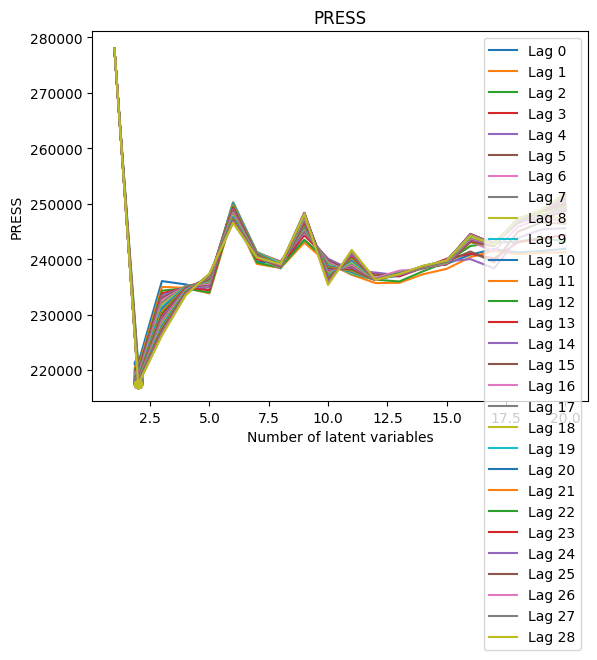

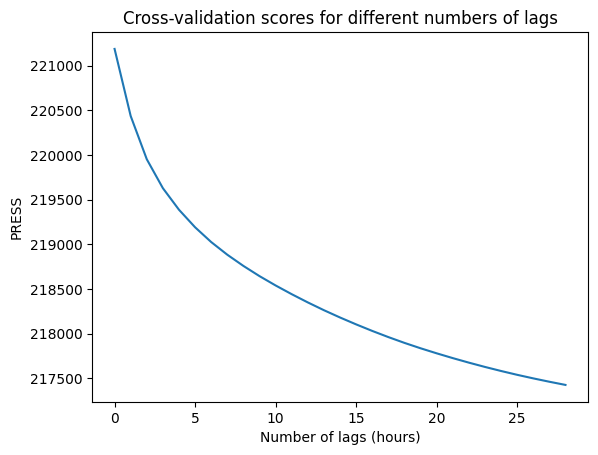

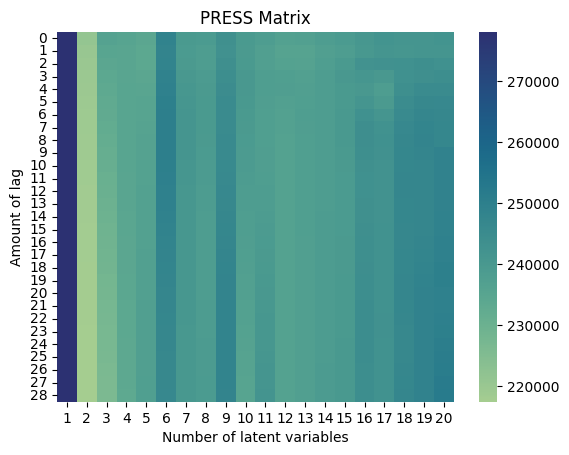

In [403]:
from sklearn.cross_decomposition import PLSRegression
import warnings
warnings.filterwarnings('ignore')

press_matrix = np.zeros_like(models)

cv_scores_lags = np.zeros(len(lags_range)) # cross-validation scores for lags
cv_lv_nums = np.zeros(len(lags_range)) # optimal number of lv for different lags
for i, lags in enumerate(lags_range):

    press_vec = np.zeros(max_lv-1) # vector to store PRESS values

    # Make lagged validation set
    X_val_lagged, y_val_lagged = make_lagged(X_val, y_val, lags, lagged_columns)

    # Cross validate the model over different number of latent variables
    for j, num_lvs in enumerate(lv_range):

        # Predict the validation set using the model
        y_pred = models[i, j].predict(X_val_lagged)

        # PRESS
        press_score = np.sum( (y_pred - y_val_lagged)**2 )
        press_vec[j] = press_score
        press_matrix[i, j] = press_score

    cv_lv_nums[i] = np.argmin(press_vec) + 1 # optimal lv number
    cv_scores_lags[i] = np.min(press_vec) # cross-validation score

    line, = plt.plot(lv_range, press_vec, label=f'Lag {max(lags)}')
    plt.plot(np.argmin(press_vec) + 1, np.min(press_vec), "ro", color=line.get_color())

# Add titles and labels
plt.title("PRESS")
plt.xlabel("Number of latent variables")
plt.ylabel("PRESS")
plt.legend()

# Plot the 
plt.figure()
plt.plot([max(lags) for lags in lags_range], np.min(press_matrix, axis=1))
plt.xlabel("Number of lags (hours)")
plt.ylabel("PRESS")
plt.title("Cross-validation scores for different numbers of lags")
plt.show()

# PRESS scores as a heatmap
sns.heatmap(press_matrix.astype(float),
    xticklabels=lv_range,
    yticklabels=[max(lags) for lags in lags_range],
    cmap="crest"
)
plt.xlabel('Number of latent variables')
plt.ylabel('Amount of lag')
plt.title(f"PRESS Matrix")
plt.show()

---

## Model testing 

Choose the best model, and apply it to the test set

Best model: lv=2, lag=28


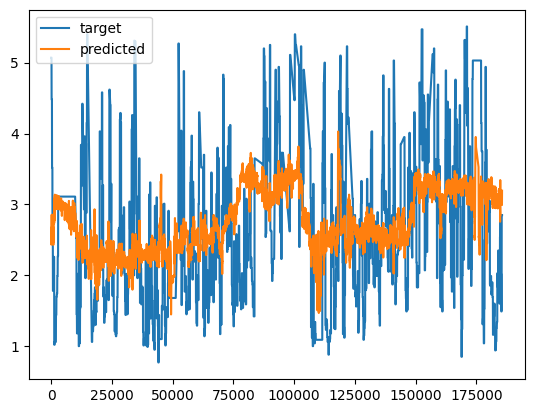

0.8876665958272087


In [404]:
i, j = np.unravel_index(press_matrix.argmin(), press_matrix.shape)
best_model: PLSRegression = models[i, j]
lags = lags_range[i]
print(f"Best model: lv={lv_range[j]}, lag={max(lags)}")

X_test_lagged, y_test_lagged = make_lagged(X_train, y_train, lags ,lagged_columns)
y_pred = best_model.predict(X_test_lagged)

x_test_lagged = np.arange(0, len(y_test_lagged))
plt.figure()
plt.plot(x_test_lagged, y_test_lagged, label='target')
plt.plot(x_test_lagged, y_pred, label='predicted')
plt.legend()
plt.show()

mean_error = np.mean(np.abs(y_test_lagged - y_pred))
print(mean_error)

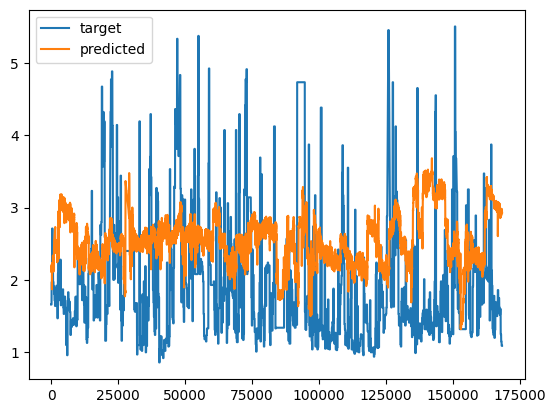

0.9850374307135016


In [405]:
X_test_lagged, y_test_lagged = make_lagged(X_val, y_val, lags ,lagged_columns)
y_pred = best_model.predict(X_test_lagged)

x_test_lagged = np.arange(0, len(y_test_lagged))
plt.figure()
plt.plot(x_test_lagged, y_test_lagged, label='target')
plt.plot(x_test_lagged, y_pred, label='predicted')
plt.legend()
plt.show()

mean_error = np.mean(np.abs(y_test_lagged - y_pred))
print(mean_error)

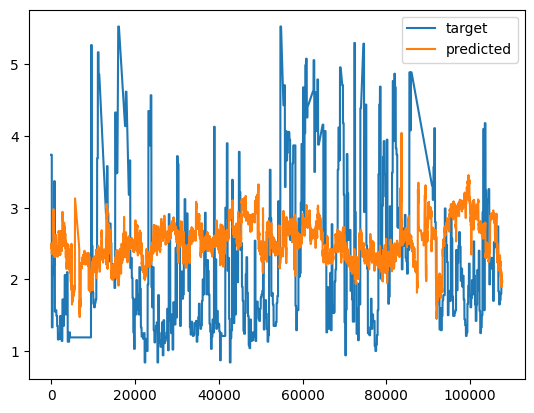

1.063658928145615


In [406]:
X_test_lagged, y_test_lagged = make_lagged(X_test, y_test, lags ,lagged_columns)
y_pred = best_model.predict(X_test_lagged)

x_test_lagged = np.arange(0, len(y_test_lagged))
plt.figure()
plt.plot(x_test_lagged, y_test_lagged, label='target')
plt.plot(x_test_lagged, y_pred, label='predicted')
plt.legend()
plt.show()

mean_error = np.mean(np.abs(y_test_lagged - y_pred))
print(mean_error)

In [ ]:
print(best_model.coef_.shape)
sorted_indices = np.argsort(best_model.coef_)
sorted_coefs = best_model.coef_.flatten()[sorted_indices].flatten()
sorted_names = best_model.feature_names_in_[sorted_indices].flatten()
print([f"{name}: {coef:.2f}" for name, coef in zip(sorted_names[-20:], sorted_coefs[-20:])])

In [48]:
pd.set_option('display.max_columns', None)
data_val.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
442471,2017-07-03 17:00:00,-0.099799,-0.264669,-0.166664,0.113671,0.465024,-0.323841,0.481457,0.586475,0.538354,0.629576,-0.069890,0.829127,0.381018,0.074857,-0.705705,-0.868931,-0.582653,-0.440310,-0.243846,-0.185072,-0.306099,0.098272,-0.201468
442472,2017-07-03 17:00:00,-0.099799,-0.264669,-0.107069,0.185062,-0.160660,-0.324383,0.476258,0.592957,0.578853,0.637245,-0.053952,0.553868,-0.071795,0.205899,-0.885447,-0.849339,-0.637114,-0.436028,-0.093010,-0.281520,-0.211590,0.098272,-0.201468
442473,2017-07-03 17:00:00,-0.099799,-0.264669,-0.011636,0.131056,0.626677,-0.323763,0.470915,0.593227,0.780117,0.654332,0.258969,0.696585,0.098568,0.471228,-0.851176,-0.688624,-0.607858,0.054241,-0.208665,-0.333210,-0.167593,0.098272,-0.201468
442474,2017-07-03 17:00:00,-0.099799,-0.264669,0.109397,0.169563,0.530695,-0.323143,0.465572,0.706929,0.843833,0.799544,1.320178,1.106860,0.406069,0.789992,-0.934694,-0.837705,-0.735548,0.157047,-0.195878,-0.416427,-0.237317,0.098272,-0.201468
442475,2017-07-03 17:00:00,-0.099799,-0.264669,0.248871,0.178946,0.363990,-0.322549,0.460373,0.740891,1.072163,0.697402,0.280737,0.393003,0.284981,0.666134,-1.009449,-0.960461,-0.901828,-0.037540,-0.084434,-0.525482,-0.193544,0.098272,-0.201468


In [76]:
def make_lagged2(X, y, num_lags):
  hour_freq_vars = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate']
  columns_high_freq = list( X.columns.values.copy() )
  [columns_high_freq.remove(col) for col in hour_freq_vars]

  lagged_data = X.copy()
  for i in range(1, num_lags+1):
    lag_data = X[columns_high_freq].shift(i).add_suffix('.L' + str(i))
    lagged_data = pd.concat([lagged_data, lag_data], axis=1)

  return lagged_data.dropna(axis=0), y[num_lags:]

X_r, y_r = make_lagged2(X_val, y_val, 2)
X_r.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,Starch Flow.L1,Amina Flow.L1,Ore Pulp Flow.L1,Ore Pulp pH.L1,Ore Pulp Density.L1,Flotation Column 01 Air Flow.L1,Flotation Column 02 Air Flow.L1,Flotation Column 03 Air Flow.L1,Flotation Column 04 Air Flow.L1,Flotation Column 05 Air Flow.L1,Flotation Column 06 Air Flow.L1,Flotation Column 07 Air Flow.L1,Flotation Column 01 Level.L1,Flotation Column 02 Level.L1,Flotation Column 03 Level.L1,Flotation Column 04 Level.L1,Flotation Column 05 Level.L1,Flotation Column 06 Level.L1,Flotation Column 07 Level.L1,Starch Flow.L2,Amina Flow.L2,Ore Pulp Flow.L2,Ore Pulp pH.L2,Ore Pulp Density.L2,Flotation Column 01 Air Flow.L2,Flotation Column 02 Air Flow.L2,Flotation Column 03 Air Flow.L2,Flotation Column 04 Air Flow.L2,Flotation Column 05 Air Flow.L2,Flotation Column 06 Air Flow.L2,Flotation Column 07 Air Flow.L2,Flotation Column 01 Level.L2,Flotation Column 02 Level.L2,Flotation Column 03 Level.L2,Flotation Column 04 Level.L2,Flotation Column 05 Level.L2,Flotation Column 06 Level.L2,Flotation Column 07 Level.L2
442473,-0.099799,-0.264669,-0.011636,0.131056,0.626677,-0.323763,0.470915,0.593227,0.780117,0.654332,0.258969,0.696585,0.098568,0.471228,-0.851176,-0.688624,-0.607858,0.054241,-0.208665,-0.333210,-0.167593,0.098272,-0.107069,0.185062,-0.160660,-0.324383,0.476258,0.592957,0.578853,0.637245,-0.053952,0.553868,-0.071795,0.205899,-0.885447,-0.849339,-0.637114,-0.436028,-0.093010,-0.281520,-0.211590,-0.166664,0.113671,0.465024,-0.323841,0.481457,0.586475,0.538354,0.629576,-0.069890,0.829127,0.381018,0.074857,-0.705705,-0.868931,-0.582653,-0.440310,-0.243846,-0.185072,-0.306099
442474,-0.099799,-0.264669,0.109397,0.169563,0.530695,-0.323143,0.465572,0.706929,0.843833,0.799544,1.320178,1.106860,0.406069,0.789992,-0.934694,-0.837705,-0.735548,0.157047,-0.195878,-0.416427,-0.237317,0.098272,-0.011636,0.131056,0.626677,-0.323763,0.470915,0.593227,0.780117,0.654332,0.258969,0.696585,0.098568,0.471228,-0.851176,-0.688624,-0.607858,0.054241,-0.208665,-0.333210,-0.167593,-0.107069,0.185062,-0.160660,-0.324383,0.476258,0.592957,0.578853,0.637245,-0.053952,0.553868,-0.071795,0.205899,-0.885447,-0.849339,-0.637114,-0.436028,-0.093010,-0.281520,-0.211590
442475,-0.099799,-0.264669,0.248871,0.178946,0.363990,-0.322549,0.460373,0.740891,1.072163,0.697402,0.280737,0.393003,0.284981,0.666134,-1.009449,-0.960461,-0.901828,-0.037540,-0.084434,-0.525482,-0.193544,0.098272,0.109397,0.169563,0.530695,-0.323143,0.465572,0.706929,0.843833,0.799544,1.320178,1.106860,0.406069,0.789992,-0.934694,-0.837705,-0.735548,0.157047,-0.195878,-0.416427,-0.237317,-0.011636,0.131056,0.626677,-0.323763,0.470915,0.593227,0.780117,0.654332,0.258969,0.696585,0.098568,0.471228,-0.851176,-0.688624,-0.607858,0.054241,-0.208665,-0.333210,-0.167593
442476,-0.099799,-0.264669,0.349101,0.130935,0.399764,-0.321929,0.455030,0.726509,0.788940,0.682941,-0.830228,-0.142940,0.013684,-0.017191,-1.055710,-0.932645,-1.038010,0.105617,0.019545,-0.472613,-0.361040,0.098272,0.248871,0.178946,0.363990,-0.322549,0.460373,0.740891,1.072163,0.697402,0.280737,0.393003,0.284981,0.666134,-1.009449,-0.960461,-0.901828,-0.037540,-0.084434,-0.525482,-0.193544,0.109397,0.169563,0.530695,-0.323143,0.465572,0.706929,0.843833,0.799544,1.320178,1.106860,0.406069,0.789992,-0.934694,-0.837705,-0.735548,0.157047,-0.195878,-0.416427,-0.237317
442477,-0.099799,-0.264669,0.404063,0.172193,0.091098,-0.321334,0.449832,0.717394,0.876935,0.682065,0.708330,-0.541392,0.398921,0.356474,-1.048513,-0.950685,-1.118883,0.012321,-0.186355,-

In [77]:
y_r

,% Silica Concentrate
442473,-0.201468
442474,-0.201468
442475,-0.201468
442476,-0.201468
442477,-0.201468
...,...
589957,-0.077085
589958,-0.077085
589959,-0.077085
589960,-0.077085
